In [ ]:
import torch
import torch.distributions as dist # PyTorch distributions library
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sample_anchors import sample_concentrating_sphere, project_onto_planes, concentration_parameter_tensor

# --- 设置随机数种子 ---
SEED = 42
torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(SEED)
print(f"使用 PyTorch 随机数种子: {SEED}，采样将是确定性的。")


: 

In [24]:

# 定义一批半径
r = torch.linspace(0.5, 32-0.5, 32, device='cuda')
n_samples_per = 1600 # 每个半径采样500个点
device = 'cpu'
print(f"Using device: {device}")

# 调用批处理采样函数
spherical_coordinates = sample_concentrating_sphere(
    r, n_samples_per, threshold=0,device=device
)

print(f"Output spherical_coordinates shape: {spherical_coordinates.shape}") # 应为 [4 * 500, 3]


Using device: cpu
Output spherical_coordinates shape: torch.Size([51200, 3])


In [25]:
spherical_coordinates[:,2].min()

tensor(-0.9683)

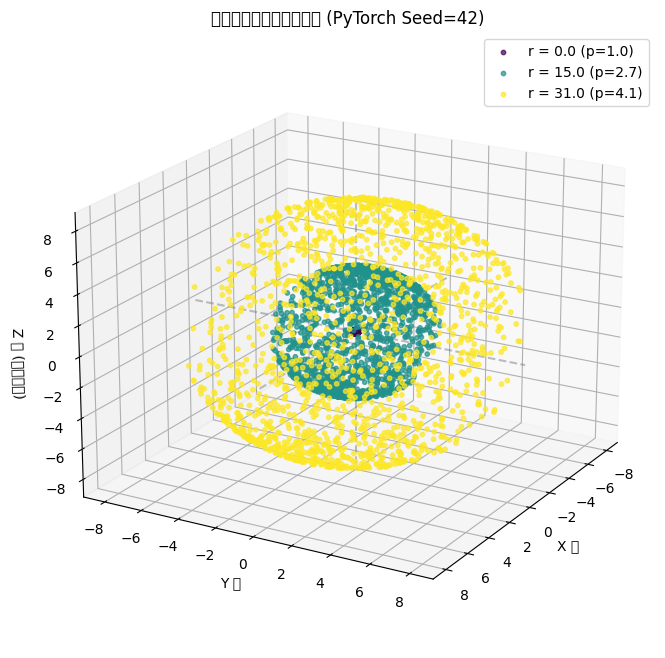

In [26]:
# --- 可视化 (与之前类似，但从批处理结果中提取数据) ---
radii_batch_np = [0,15,31]
r_max = 8.0
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, len(radii_batch_np)))

max_r_plot = r_max * 1.1
ax.plot([-max_r_plot, max_r_plot], [0,0], [0,0], color='gray', linestyle='--', alpha=0.5)
ax.plot([0,0], [-max_r_plot, max_r_plot], [0,0], color='gray', linestyle='--', alpha=0.5)
ax.plot([0,0], [0,0], [-max_r_plot, max_r_plot], color='gray', linestyle='--', alpha=0.5)

# 遍历每个半径的结果进行绘图
for i in range(len(radii_batch_np)):
    r_val = radii_batch_np[i]
    # 提取第 i 个半径对应的 theta, phi, r
    start = r_val * n_samples_per
    end = (r_val + 1) * n_samples_per
    theta_i = 2 * np.pi * (spherical_coordinates[start:end,0].cpu().detach().numpy() + 1) / 2 # shape [n_samples_per]
    phi_i = np.pi * (spherical_coordinates[start:end,1].cpu().detach().numpy() + 1) / 2   # shape [n_samples_per]
    r_i = (spherical_coordinates[start:end,2].cpu().detach().numpy() + 1) * r_max / 2    # shape [n_samples_per], all values should be r_val

    # 转换为笛卡尔坐标用于绘图
    x_coords_np = -r_i * np.sin(phi_i) * np.sin(theta_i)
    z_coords_np = -r_i * np.sin(phi_i) * np.cos(theta_i)
    y_coords_np = -r_i * np.cos(phi_i)
    p_val = concentration_parameter_tensor(r[r_val]).item() # 计算对应的 p 值
    ax.scatter(x_coords_np, y_coords_np, z_coords_np,
                label=f'r = {r_val:.1f} (p={p_val:.1f})',
                color=colors[i],
                s=10,
                alpha=0.7)

# --- 美化图形 ---
ax.set_title(f'确定性球坐标批处理采样 (PyTorch Seed={SEED})')
ax.set_xlabel('X 轴')
ax.set_ylabel('Y 轴')
ax.set_zlabel('Z 轴 (垂直方向)')

max_r_limit = r_max * 1.1
ax.set_xlim([-max_r_limit, max_r_limit])
ax.set_ylim([-max_r_limit, max_r_limit])
ax.set_zlim([-max_r_limit, max_r_limit])
ax.legend()
ax.view_init(elev=20., azim=30)
try:
    ax.set_aspect('equal', adjustable='box')
except NotImplementedError:
    print("Warning: Axes3D.set_aspect('equal') not fully supported.")

plt.show()

In [27]:
(spherical_coordinates[start:end,2].cpu().detach().numpy() + 1).max()

2.0

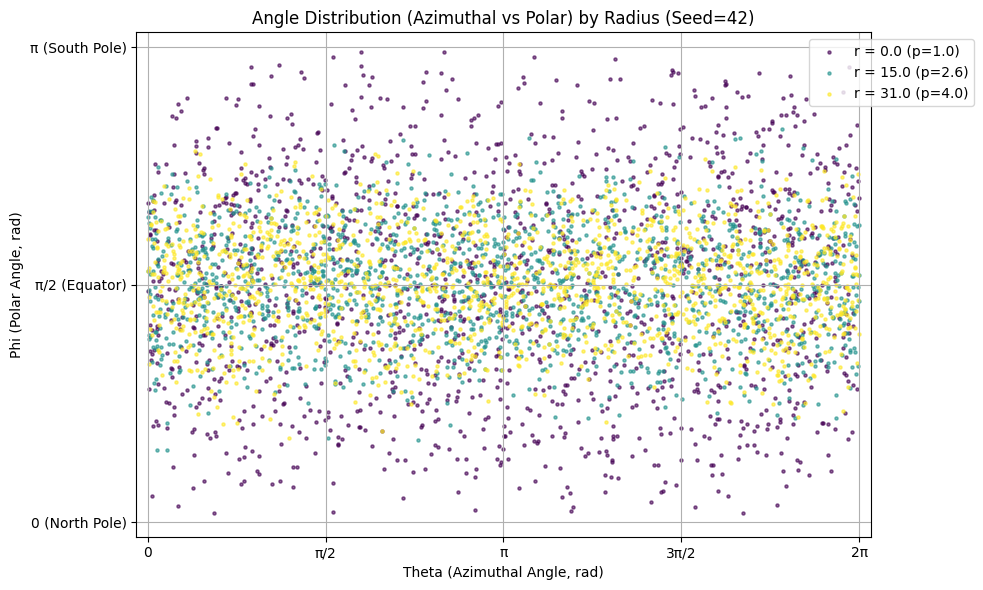

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# No longer need 3D toolkit
# from mpl_toolkits.mplot3d import Axes3D
import math # Needed for pi

# Assume these variables are available from the previous sampling step:
# theta_batch: torch.Tensor, shape [N_radii, n_samples], Azimuthal angle [0, 2*pi)
# phi_batch:   torch.Tensor, shape [N_radii, n_samples], Polar angle [0, pi]
# radii_batch_np: np.array, shape [N_radii], the radii used for sampling
# SEED: The random seed used
# concentration_parameter_tensor: The function to calculate 'p'

# --- 可视化 Theta vs Phi (Azimuthal vs Polar) ---
fig, ax = plt.subplots(figsize=(10, 6)) # Create a 2D axes object
colors = plt.cm.viridis(np.linspace(0, 1, len(radii_batch_np)))

# 遍历每个半径的结果进行绘图
for i in range(len(radii_batch_np)):
    r_val = radii_batch_np[i]
    
    start = r_val * n_samples_per
    end = (r_val + 1) * n_samples_per
    # --- Correctly extract theta and phi for radius i ---
    # theta_batch[i] contains azimuthal angles [0, 2*pi)
    # phi_batch[i] contains polar angles [0, pi]
    theta_i_np = 2 * np.pi * (spherical_coordinates[start:end,0].cpu().detach().numpy() + 1) / 2 # shape [n_samples_per]
    phi_i_np = np.pi * (spherical_coordinates[start:end,1].cpu().detach().numpy() + 1) / 2   # shape [n_samples_per]

    # --- Calculate p value (make sure concentration_parameter_tensor is defined) ---
    try:
        p_val = concentration_parameter_tensor(torch.tensor(r_val)).item()
    except NameError:
        print("Warning: concentration_parameter_tensor function not found. Cannot display p-value.")
        p_val = "N/A" # Placeholder if function is missing
    except Exception as e:
        print(f"Warning: Error calculating p-value: {e}. Cannot display p-value.")
        p_val = "Error"


    # --- Plot 2D Scatter: theta vs phi ---
    ax.scatter(theta_i_np, phi_i_np, # X-axis is theta, Y-axis is phi
               label=f'r = {r_val:.1f} (p={p_val if isinstance(p_val, str) else f"{p_val:.1f}"})',
               color=colors[i],
               s=5,           # Use smaller points for potentially dense plots
               alpha=0.6)      # Adjust alpha for overlap visibility

# --- 美化图形 ---
# Assuming SEED is defined elsewhere
title = f'Angle Distribution (Azimuthal vs Polar) by Radius'
if 'SEED' in locals() or 'SEED' in globals():
    title += f' (Seed={SEED})'
ax.set_title(title)
ax.set_xlabel('Theta (Azimuthal Angle, rad)') # Updated label
ax.set_ylabel('Phi (Polar Angle, rad)')     # Updated label

# 设置坐标轴范围 for angles
ax.set_xlim([-0.1, 2 * np.pi + 0.1]) # Theta range [0, 2*pi] with padding
ax.set_xticks(np.linspace(0, 2*np.pi, 5)) # Set ticks for radians (0, pi/2, pi, 3pi/2, 2pi)
ax.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

ax.set_ylim([-0.1, np.pi + 0.1])     # Phi range [0, pi] with padding
ax.set_yticks(np.linspace(0, np.pi, 3)) # Set ticks for radians (0, pi/2, pi)
ax.set_yticklabels(['0 (North Pole)', 'π/2 (Equator)', 'π (South Pole)'])


ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0)) # Adjust legend position if needed
ax.grid(True)

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

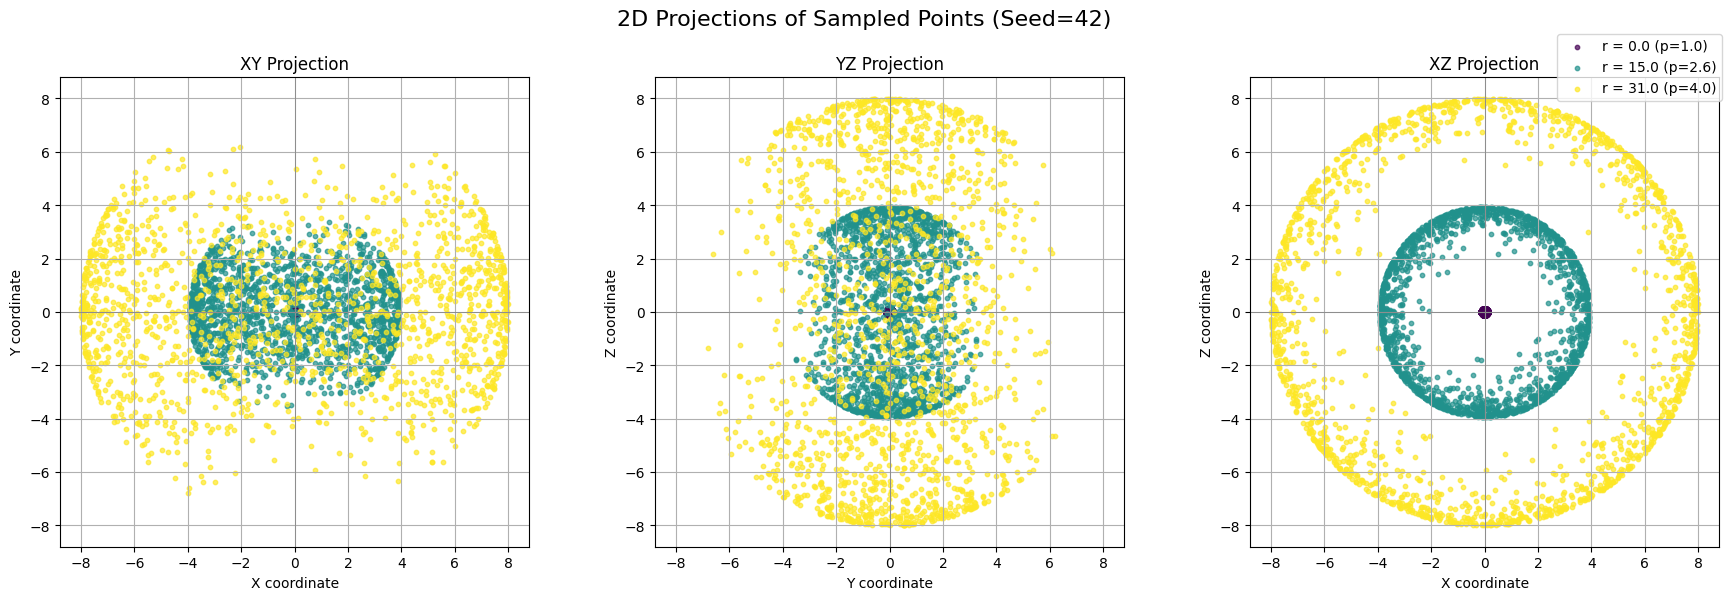

In [29]:
# --- Create 3 subplots (1 row, 3 columns) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Adjust figsize as needed
colors = plt.cm.viridis(np.linspace(0, 1, len(radii_batch_np)))
max_r_limit = r_max * 1.1

# Prepare storage for legend handles (to avoid duplicate labels)
legend_handles = []
legend_labels = []

# 遍历每个半径的结果进行绘图
for i in range(len(radii_batch_np)):
    r_val = radii_batch_np[i]

    # --- Data Extraction and Denormalization ---
    start = r_val * n_samples_per # Corrected start index based on loop index i
    end = (r_val + 1) * n_samples_per

    # Check bounds
    if start >= spherical_coordinates.shape[0] or end > spherical_coordinates.shape[0]:
        print(f"Warning: Index out of bounds for r_val={r_val}. Skipping.")
        continue

    # Denormalize angles and radius based on your formulas
    # Assuming spherical_coordinates[:, 0] is normalized theta -> [0, 2*pi)
    theta_i = 2 * np.pi * (spherical_coordinates[start:end, 0].cpu().detach().numpy() + 1) / 2
    # Assuming spherical_coordinates[:, 1] is normalized phi -> [0, pi]
    phi_i = np.pi * (spherical_coordinates[start:end, 1].cpu().detach().numpy() + 1) / 2
    # Assuming spherical_coordinates[:, 2] is normalized radius -> [0, r_max]
    r_i = (spherical_coordinates[start:end, 2].cpu().detach().numpy() + 1) * r_max / 2

    # --- Convert to Cartesian Coordinates (using your provided formula) ---
    x_coords_np = -r_i * np.sin(phi_i) * np.sin(theta_i)
    z_coords_np = -r_i * np.sin(phi_i) * np.cos(theta_i) # Z depends on cos(theta) here
    y_coords_np = -r_i * np.cos(phi_i)                  # Y depends on cos(phi)

    # --- Calculate p_val (Ensure r_val tensor is on the correct device) ---
    try:
        # Pass a tensor with the single radius value
        p_val = concentration_parameter_tensor(torch.tensor([r_val], device=device)).item()
    except Exception as e:
        print(f"Error calculating p_val for r={r_val}: {e}")
        p_val = "Error"

    label = f'r = {r_val:.1f} (p={p_val if isinstance(p_val, str) else f"{p_val:.1f}"})'

    # --- Plot Projections on Subplots ---
    # XY Projection (axes[0])
    scatter_xy = axes[0].scatter(x_coords_np, y_coords_np,
                   color=colors[i], s=10, alpha=0.7)
    # YZ Projection (axes[1]) - Plotting Y on X-axis, Z on Y-axis
    scatter_yz = axes[1].scatter(y_coords_np, z_coords_np,
                   color=colors[i], s=10, alpha=0.7)
    # XZ Projection (axes[2])
    scatter_xz = axes[2].scatter(x_coords_np, z_coords_np,
                   color=colors[i], s=10, alpha=0.7)

    # Store handle for legend only once per radius
    if i == 0: # Add handle for the first point of this color
        legend_handles.append(scatter_xy) # Can use any scatter plot handle for this color
        legend_labels.append(label)
    elif len(legend_handles) <= i: # Add handle if not already added for this index
         legend_handles.append(scatter_xy)
         legend_labels.append(label)


# --- Beautify Each Subplot ---
subplot_titles = ['XY Projection', 'YZ Projection', 'XZ Projection']
x_labels = ['X coordinate', 'Y coordinate', 'X coordinate']
y_labels = ['Y coordinate', 'Z coordinate', 'Z coordinate']

for j, ax in enumerate(axes):
    ax.set_title(subplot_titles[j])
    ax.set_xlabel(x_labels[j])
    ax.set_ylabel(y_labels[j])
    # Set limits based on max radius for all plots
    ax.set_xlim([-max_r_limit, max_r_limit])
    ax.set_ylim([-max_r_limit, max_r_limit])
    ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
    ax.grid(True)
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(0.98, 0.95))
fig.suptitle(f'2D Projections of Sampled Points (Seed={SEED})', fontsize=16) # Overall title

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap, leave space for suptitle
plt.show()